### Installing the latest version of fastai

In [1]:
!pip install torch --upgrade

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.0+cu101)


In [2]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 11.3MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 12.8MB 238kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


### Library Imports

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Function to Extract only Jet particles

In [2]:
def only_jets(df):    
    ignore_particles = ['e-', 'e+', 'm-', 'm+', 'g', 'b']
    ignore_list = []
    for i in range(len(df)):
        for j in df.loc[i].keys():
            if 'obj' in j:
                if df.loc[i][j] in ignore_particles:
                    ignore_list.append(i)
                    break

    print(ignore_list)

    df = df.drop(ignore_list)

### Some helper Functions

In [56]:
def std_error(x, axis=None, ddof=0):
    return np.nanstd(x, axis=axis, ddof=ddof) / np.sqrt(2 * len(x))

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorsys import hsv_to_rgb


def set_my_style():
    # lines
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['lines.color'] = 'r'

    # axis
    mpl.rcParams['axes.titlesize'] = 26
    mpl.rcParams['axes.grid'] = True


def sciy():
    plt.gca().ticklabel_format(style='sci', scilimits=(0, 0), axis='y')


def scix():
    plt.gca().ticklabel_format(style='sci', scilimits=(0, 0), axis='x')


def colorprog(i_prog, Nplots, v1=.9, v2=1., cm='hsv'):
    if hasattr(Nplots, '__len__'):
        Nplots = len(Nplots)
    if cm == 'hsv':
        return hsv_to_rgb(float(i_prog) / float(Nplots), v1, v2)
    elif cm == 'rainbow':
        return [plt.cm.rainbow(k) for k in np.linspace(0, 1, Nplots)][i_prog]
    else:
        raise ValueError('What?!')

### Function to Create dataset from the raw Data

In [3]:
def csv_to_df(input_path, save_path):
    data = []    
    print('Reading data at ', input_path)
    with open(input_path, 'r') as file:
        for line in file.readlines():
            line = line.replace(';', ',')
            line = line.rstrip(',\n')
            line = line.split(',')
            data.append(line)

    #Find the longest line in the data 
    longest_line = max(data, key = len)

    #Set the maximum number of columns
    max_col_num = len(longest_line)

    #Set the columns names
    col_names = ['event_ID', 'process_ID', 'event_weight', 'MET', 'MET_Phi']
    meta_cols = col_names.copy()

    for i in range(1, (int((max_col_num-5)/5))+1):
        col_names.append('obj'+str(i))
        col_names.append('E'+str(i))
        col_names.append('pt'+str(i))
        col_names.append('eta'+str(i))
        col_names.append('phi'+str(i))


    print('Processing the data..')
    df = pd.DataFrame(data, columns=col_names)
    df.fillna(value=np.nan, inplace=True)

    one_hot = pd.get_dummies(df['process_ID'])

    

    # Create the train-test split
    x_train, x_test, _, _ = train_test_split(df.values, one_hot.values, 
                                                shuffle = True,
                                                random_state = 42,
                                                test_size = 0.1)
    
    del df
    x_train_df = pd.DataFrame(x_train, columns=col_names)
    x_train_df.fillna(value=0, inplace=True)
    x_test_df = pd.DataFrame(x_test, columns=col_names)
    x_test_df.fillna(value=0, inplace=True)

    meta_train_df = x_train_df[meta_cols]
    meta_train_df.to_pickle(save_path + '_metaData_train.pkl')

    meta_test_df = x_test_df[meta_cols]
    meta_test_df.to_pickle(save_path + '_metaData_test.pkl')

    x_train_df = x_train_df.drop(columns=meta_cols)
    x = x_train_df.values.reshape([x_train_df.shape[0]*x_train_df.shape[1]//5,5])

    lst = []
    for i in range(x.shape[0]):
        if (x[i] == 0).all():
            lst.append(i)
    data_train = np.delete(x, lst, 0)

    x_test_df = x_test_df.drop(columns=meta_cols)
    x = x_test_df.values.reshape([x_test_df.shape[0]*x_test_df.shape[1]//5,5])

    lst = []
    for i in range(x.shape[0]):
        if (x[i] == 0).all():
            lst.append(i)
    data_test = np.delete(x, lst, 0)

    col_names = ['obj', 'E', 'pt', 'eta', 'phi']

    data_train_df = pd.DataFrame(data_train, columns=col_names)
    data_train_df['obj'].to_pickle(save_path + '_meta_obj_train.pkl')

    data_test_df = pd.DataFrame(data_test, columns=col_names)
    data_test_df['obj'].to_pickle(save_path + '_meta_obj_test.pkl')

    only_jets(data_train_df)
    only_jets(data_test_df)

    data_train_df = data_train_df.drop(columns='obj')
    data_test_df = data_test_df.drop(columns='obj')
    
    data_train_df = data_train_df.astype('float32')
    data_test_df = data_test_df.astype('float32')

    data_train_df.to_pickle(save_path + '_4D_train.pkl')
    data_test_df.to_pickle(save_path + '_4D_test.pkl')

    return


    


In [4]:
csv_to_df("/content/drive/MyDrive/monojet_Zp2000.0_DM_50.0_chan3.csv", "/content/drive/MyDrive/Deep Compression Task/Pickled Data/")

Reading data at  /content/drive/MyDrive/monojet_Zp2000.0_DM_50.0_chan3.csv
Processing the data..
[4, 92, 97, 104, 138, 148, 221, 262, 334, 350, 352, 359, 373, 376, 471, 494, 534, 573, 601, 610, 622, 653, 656, 707, 712, 717, 741, 744, 759, 760, 766, 834, 835, 843, 895, 948, 977, 1026, 1040, 1041, 1064, 1067, 1069, 1080, 1196, 1224, 1254, 1261, 1309, 1328, 1343, 1344, 1345, 1377, 1385, 1432, 1446, 1541, 1627, 1637, 1643, 1665, 1674, 1683, 1710, 1722, 1735, 1748, 1771, 1885, 1915, 1935, 1991, 1998, 2050, 2077, 2079, 2097, 2100, 2117, 2161, 2212, 2213, 2216, 2224, 2228, 2258, 2291, 2292, 2323, 2339, 2347, 2410, 2439, 2449, 2452, 2454, 2465, 2469, 2488, 2519, 2520, 2521, 2550, 2568, 2579, 2580, 2591, 2593, 2598, 2599, 2664, 2756, 2765, 2777, 2806, 2828, 2836, 2852, 2865, 2892, 2893, 2913, 2975, 2993, 3008, 3010, 3012, 3048, 3049, 3105, 3117, 3120, 3129, 3164, 3243, 3285, 3318, 3342, 3351, 3418, 3459, 3535, 3536, 3547, 3561, 3572, 3581, 3587, 3608, 3629, 3653, 3733, 3782, 3838, 3870, 4057, 4

In [5]:
train = pd.read_pickle("/content/drive/MyDrive/Deep Compression Task/Pickled Data/_4D_train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Deep Compression Task/Pickled Data/_4D_test.pkl")

In [6]:
train.shape

(21105, 4)

In [7]:
test.head()

,E,pt,eta,phi
0,991867.000000,818339.000000,-0.637444,0.643446
1,209093.000000,178835.000000,0.506598,-2.294510
2,55242.101562,43436.500000,-0.683999,-1.945310
3,505625.000000,33674.601562,-3.400870,2.941330
4,498470.000000,30339.699219,3.491140,-2.627340


## Data Normalization


Parameters for custom normalization:
        \begin{equation}
                E \xrightarrow . ([log_{10}(E / 1000) ]  + 1) / 1.8 \\
                p_t \xrightarrow . ([log_{10}(p_t / 1000) ]  - 1.3) / 1.2 \\
                \eta \xrightarrow . \eta / 5 \\
                \phi \xrightarrow . \phi / 3 \\
        \end{equation}

In [8]:
variables = test.keys()

train['E'] = train['E'] / 1000.0
train['pt'] = train['pt'] / 1000.0
test['E'] = test['E'] / 1000.0
test['pt'] = test['pt'] / 1000.0

train['eta'] = train['eta'] / 5
train['phi'] = train['phi'] / 3
train['E'] = np.log10(train['E']) 
train['pt'] = np.log10(train['pt'])

test['eta'] = test['eta'] / 5
test['phi'] = test['phi'] / 3
test['E'] = np.log10(test['E']) 
test['pt'] = np.log10(test['pt'])

print(test.shape)

(2368, 4)


### Essential factors for custom normalization

In [9]:
m_div = 1.8
m_add = 1
pt_sub = 1.3
pt_div = 1.2
eta_div = 5
phi_div = 3


### Function for custom normalization

In [10]:
def custom_normalization(train, test):
    train_cp = train.copy()
    test_cp = test.copy()
    
    for data in [train_cp, test_cp]:
        data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div
        data['phi'] = data['phi'] / phi_div
        data['eta'] = data['eta'] / eta_div
        data['E'] = np.log10(data['E'] + m_add) / m_div

    return train_cp, test_cp

In [36]:
def custom_unnormalize_4m(normalized_data):
    data = normalized_data.copy()
    data[:,0] = np.power(10, data[:,0]) - m_add 
    data[:,1] = np.power(10, data[:,1]) + pt_sub 
    data[:,2] = data[:,2] * phi_div
    data[:,3] = data[:,3] * eta_div
    return data

In [11]:
train, test = custom_normalization(train, test)

In [12]:
for key in test.keys():
    print(key)

E
pt
eta
phi


In [13]:
len(test.keys())

4

In [14]:
test.head()

,E,pt,eta,phi
0,0.334264,-0.696391,-0.025498,0.071494
1,0.289546,-0.789454,0.020264,-0.254946
2,0.243395,-0.904770,-0.027360,-0.216146
3,0.315917,-0.930062,-0.136035,0.326814
4,0.315514,-0.940957,0.139646,-0.291927


## Visualizing normalized data

In [43]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            sciy()

### Training data

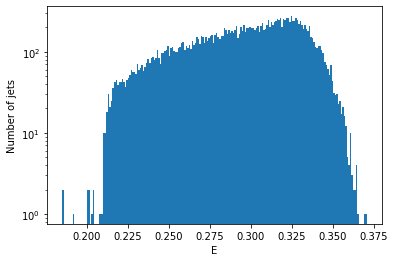

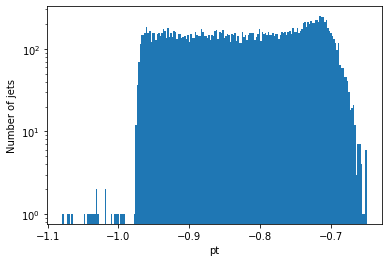

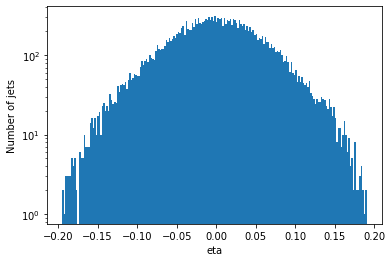

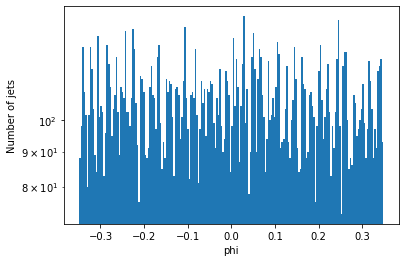

In [42]:
logy = True
plot_all(train, logy)

### Validation data

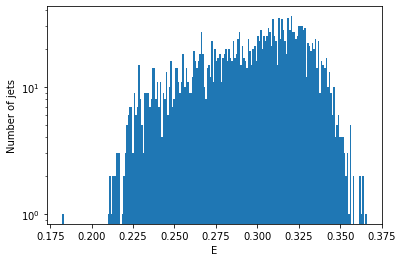

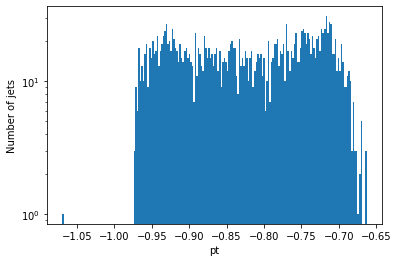

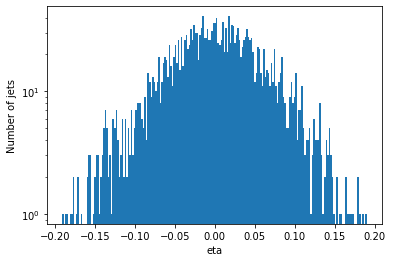

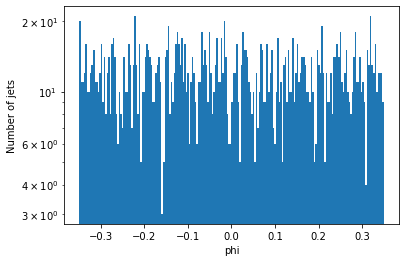

In [18]:
logy = True
plot_all(test, logy)

### Creating a databunch for training

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data 
from torch.autograd import Variable 

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))


In [20]:
bs = 256

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Model Architecture


In [21]:
class AE_bn_LeakyReLU(nn.Module):
    def __init__(self, nodes, no_last_bias=False):
        super(AE_bn_LeakyReLU, self).__init__()
        n_layers = len(nodes)
        ins_n_outs = []
        en_modulelist = nn.ModuleList()
        de_modulelist = nn.ModuleList()
        for ii in range(n_layers // 2):
            ins = nodes[ii]
            outs = nodes[ii + 1]
            ins_n_outs.append((ins, outs))
            en_modulelist.append(nn.Linear(ins, outs))
            en_modulelist.append(nn.LeakyReLU())
            en_modulelist.append(nn.BatchNorm1d(outs))
        for ii in range(n_layers // 2):
            ii += n_layers // 2
            ins = nodes[ii]
            outs = nodes[ii + 1]
            de_modulelist.append(nn.Linear(ins, outs))
            de_modulelist.append(nn.LeakyReLU())
            de_modulelist.append(nn.BatchNorm1d(outs))

        de_modulelist = de_modulelist[:-2]  # Remove LeakyReLU activation and BatchNorm1d from output layer
        if no_last_bias:
            de_modulelist = de_modulelist[:-1]
            de_modulelist.append(nn.Linear(nodes[-2], nodes[-1], bias=False))

        self.encoder = nn.Sequential(*en_modulelist)
        self.decoder = nn.Sequential(*de_modulelist)

        node_string = ''
        for layer in nodes:
            node_string = node_string + str(layer) + '-'
        node_string = node_string[:-1]
        self.node_string = node_string

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

    def get_node_string(self):
        return self.node_string

### Model Building

In [22]:
nodes = [4, 200, 100, 50, 3, 200, 100, 50, 4]
model = AE_bn_LeakyReLU(nodes)
model.train()

AE_bn_LeakyReLU(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=50, out_features=3, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, trac

### Loss Function and Training Parameters

In [24]:
from fastai.metrics import mse

loss_func = nn.MSELoss()
wd = 1e-2

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

### Learning Rate Plot

Learning rate with the minimum loss: 0.025118863582611083
Learning rate with the steepest gradient: 0.0002290867705596611


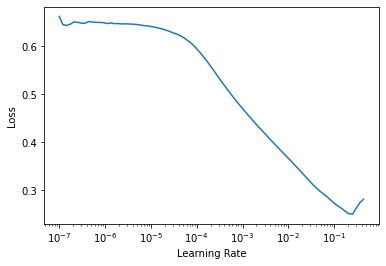

In [25]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

### Training 

In [26]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max = lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.06960633397102356, 0.01818912662565708, '00:01']
[0, 0.06960633397102356, 0.01818912662565708, '00:01']
[1, 0.014041506685316563, 0.0021215942688286304, '00:01']
[1, 0.014041506685316563, 0.0021215942688286304, '00:01']
[2, 0.004068367183208466, 0.0016445126384496689, '00:01']
[2, 0.004068367183208466, 0.0016445126384496689, '00:01']
[3, 0.0020179245620965958, 0.0012818117393180728, '00:01']
[3, 0.0020179245620965958, 0.0012818117393180728, '00:01']
[4, 0.0013265915913507342, 0.001109319506213069, '00:01']
[4, 0.0013265915913507342, 0.001109319506213069, '00:01']
[5, 0.0010833954438567162, 0.0009659550851210952, '00:01']
[5, 0.0010833954438567162, 0.0009659550851210952, '00:01']
[6, 0.0009127570083364844, 0.0008127891924232244, '00:01']
[6, 0.0009127570083364844, 0.0008127891924232244, '00:01']
[7, 0.0007414204883389175, 0.000971937901340425, '00:01']
[7, 0.0007414204883389175, 0.000971937901340425, '00:01']
[8, 0.0006799631519243121, 0.0007150604506023228, '00:01']
[8, 0.0006799

### Loss vs epoch plot

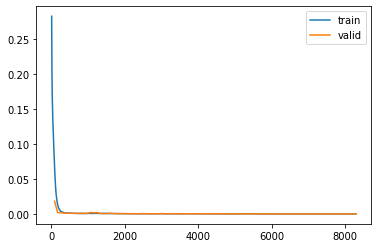

In [27]:
recorder.plot_loss()

In [44]:
learn.save('/content/drive/MyDrive/Deep Compression Task/Model/AE_3D_200_ReLU_BN_custom_norm')

Path('/content/drive/MyDrive/Deep Compression Task/Model/AE_3D_200_ReLU_BN_custom_norm.pth')

### Evaluating on the test set


In [45]:
learn.load('/content/drive/MyDrive/Deep Compression Task/Model/AE_3D_200_ReLU_BN_custom_norm')

In [54]:
learn.validate()

(#1) [7.679429472773336e-06]

In [35]:
curr_save_folder = '/content/drive/MyDrive/Deep Compression Task/plots/AE_3D_200_ReLU_BN_custom_norm/'

### Input(Uncompressed data) vs Output(Compressed data) Plot

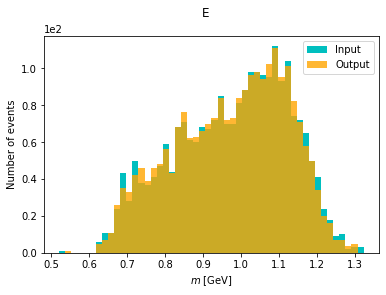

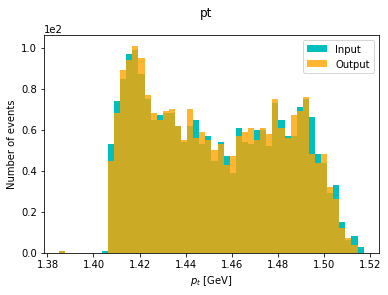

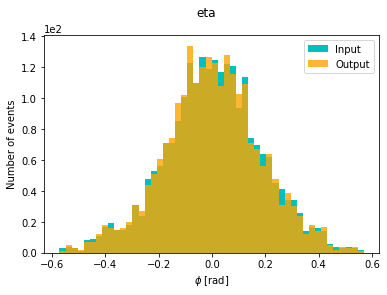

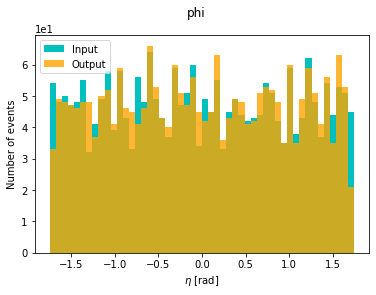

In [38]:
plt.close('all')
unit_list = ['[GeV]', '[GeV]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_t$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, len(test))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = custom_unnormalize_4m(pred)
data = custom_unnormalize_4m(data.detach().numpy())

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = '200_ReLU_BN_cus_norm_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

### Plot of relative reconstruction error for each variable

E Mean:  -0.0014671844 \pm 0.00010176111646336089  Sigma:  0.004950864 \pm 7.194077794630857e-05
pt Mean:  -0.0002668157 \pm 8.924652505074376e-06  Sigma:  0.00043420063 \pm 6.309349727859862e-06
eta Mean:  0.019458054 \pm 0.0372434633545529  Sigma:  1.8119624 \pm 0.026329543319033557
phi Mean:  -0.031896308 \pm 0.016692175218952995  Sigma:  0.81210476 \pm 0.01180065761858372


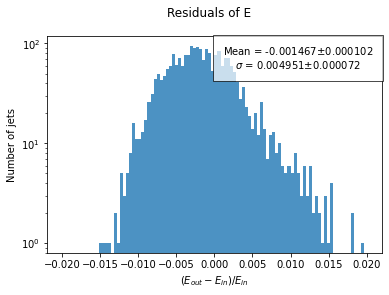

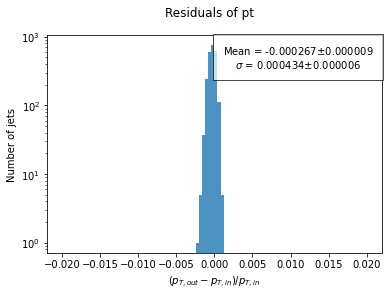

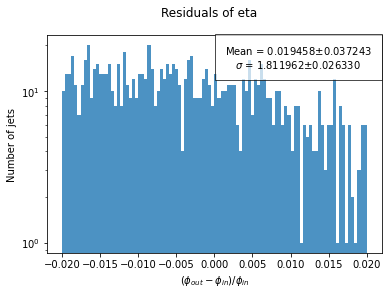

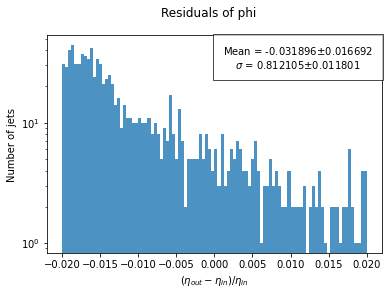

In [55]:
from scipy import stats
residual_strings = [r'$(E_{out} - E_{in}) / E_{in}$',
                    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',]

data[:,0][(data[:,0]<1e-3)] += 1
residuals = np.true_divide(pred - data, data)
range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    sciy()
    plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    print(train.columns[kk],'Mean: ', mean, '\pm', sem, ' Sigma: ', std, '\pm', std_err )
    plt.text(.75, .9, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
    fig_name = '200_ReLU_BN_cus_norm_residual_%s' % train.columns[kk]
#     plt.savefig(curr_save_folder + fig_name)